<a href="https://colab.research.google.com/github/Songnahyun/Project/blob/main/Section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data : 신용카드 사용자 연체 예측
- index
- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
- edu_type: 교육 수준
- family_type: 결혼 여부
- house_type: 생활 방식
- DAYS_BIRTH: 출생일
              데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미)

- DAYS_EMPLOYED: 업무 시작일
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미, 양수 값은 고용되지 않은 상태를 의미함
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
							 낮을 수록 높은 신용의 신용카드 사용자를 의미함



##EDA & Feature engineering

In [2]:
!pip install category_encoders

In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 6.7 MB/s 


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Section2/card_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Section2/card_test.csv')

In [6]:
train.head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0


In [7]:
train.shape, test.shape

((26457, 20), (10000, 19))

In [8]:
train['credit'].unique()

array([1., 2., 0.])

In [9]:
#target 'credit'을 이진분류로 변환 --> 0은 신용도가 높음(high), 1,2는 신용도가 낮음(low)
import numpy as np

train['Credit'] = np.nan
train.loc[train['credit'] != 0, ['Credit']] = 'low'
train.loc[train['Credit'] != 'low', ['Credit']] = 'high'
train.drop(columns = ['credit'], inplace = True)

In [10]:
train['Credit'].unique()

array(['low', 'high'], dtype=object)

In [11]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
Credit              0
dtype: int64

In [12]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

In [13]:
def engineering(df):

  # DAYS_EMPLOYED(업무 시작일)이 양수인 경우 고용되지 않은 상태이므로 0으로 처리
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x : 0 if x>0 else x)

  # occyp_type(직업 유형) null 값은 무직(inoccupation)으로 처리
  df['occyp_type'].fillna('inoccupation', inplace = True)

  # 음수값 양수로 변환
  feat = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
  for i in feat:
    df[i] = np.abs(df[i])

  # 'DAYS_BIRTH' 변수로 나이 계산하고 삭제
  df['Age'] = df['DAYS_BIRTH'] // 365
  df.drop(columns = ['DAYS_BIRTH'], inplace = True)

  # DAYS_EMPLOYED: 업무 시작일 => year_EMPLOYED(업무 연차)
  df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
  df.drop(columns = ['DAYS_EMPLOYED'], inplace = True)

  #모든 컬럼을 더하여 사용자 ID 생성, 고유값 확인 (한 사람이 카드를 만들었을 경우를 고려해 begin_month(신용카드 발급 월) 제외)
  df['ID'] = \
  df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
  df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' + \
  df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' + \
  df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
  df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
  df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
  df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str) 
  
  return df

In [14]:
engineering(train)
engineering(test)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,Age,ID
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,1,0,1,0,inoccupation,2.0,60.0,60,0_112500.0_0_1_0_2.0_M_Y_N_Pensioner_Secondary...
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,1,0,1,0,Core staff,2.0,36.0,51,0_135000.0_0_1_0_2.0_F_N_Y_State servant_Highe...
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,1,1,1,0,Laborers,2.0,40.0,43,0_69372.0_1_1_0_2.0_F_N_Y_Working_Secondary / ...
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,1,0,0,Drivers,2.0,41.0,52,0_112500.0_1_0_0_2.0_M_Y_N_Commercial associat...
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,1,1,0,0,Managers,2.0,8.0,48,0_225000.0_1_0_0_2.0_F_Y_Y_State servant_Highe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,1,1,1,0,Accountants,2.0,19.0,50,0_202500.0_1_1_0_2.0_F_Y_Y_Working_Incomplete ...
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,1,1,0,0,Laborers,2.0,34.0,29,0_202500.0_1_0_0_2.0_M_Y_Y_Working_Secondary /...
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Medicine staff,2.0,55.0,57,0_292500.0_0_0_0_2.0_F_N_Y_Working_Secondary /...
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0,inoccupation,2.0,33.0,45,0_180000.0_0_1_0_2.0_F_Y_N_Commercial associat...


In [104]:
train.head(10)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,begin_month,Credit,Age,ID
5983,M,Y,Y,0,360000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Drivers,47.0,low,37,0_360000.0_0_0_0_2.0_M_Y_Y_Working_Secondary /...
26246,F,N,N,0,157500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,28.0,low,47,0_157500.0_0_0_0_2.0_F_N_N_Commercial associat...
21804,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,inoccupation,47.0,low,37,0_180000.0_0_0_0_2.0_F_N_Y_Working_Secondary /...
1881,F,Y,Y,1,90000.0,Working,Higher education,Married,With parents,0,0,0,inoccupation,11.0,low,34,1_90000.0_0_0_0_3.0_F_Y_Y_Working_Higher educa...
15206,F,N,Y,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Laborers,13.0,high,42,1_112500.0_0_0_0_3.0_F_N_Y_Working_Secondary /...
24345,F,N,N,0,198000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0,1,0,inoccupation,12.0,low,60,0_198000.0_0_1_0_1.0_F_N_N_Pensioner_Secondary...
956,F,N,Y,0,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,inoccupation,20.0,low,65,0_180000.0_0_0_0_2.0_F_N_Y_Pensioner_Secondary...
13298,F,Y,Y,1,157500.0,Commercial associate,Secondary / secondary special,Married,With parents,1,0,0,inoccupation,5.0,low,34,1_157500.0_1_0_0_3.0_F_Y_Y_Commercial associat...
23028,F,N,N,0,112500.0,Pensioner,Secondary / secondary special,Separated,House / apartment,0,0,0,inoccupation,34.0,low,60,0_112500.0_0_0_0_1.0_F_N_N_Pensioner_Secondary...
3735,M,N,Y,0,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,6.0,low,64,0_450000.0_0_0_0_2.0_M_N_Y_Commercial associat...


In [16]:
def log(df):
  #numerical 변수와 categorical 변수 나누기
  numerical_feats = df.dtypes[df.dtypes != "object"].index 
  print("Number of Numerical features: ", len(numerical_feats)) 
  categorical_feats = df.dtypes[df.dtypes == "object"].index 
  print("Number of Categorical features: ", len(categorical_feats))

  #numerical 변수 왜도, 첨도
  for col in numerical_feats: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(df[col].skew()) , 
          ' ' , 
          'Kurtosis: {:06.2f}'.format(df[col].kurt()))

In [17]:
log(train) #'child_num', 'income_total'이 왜도와 첨도가 높다.

Number of Numerical features:  10
Number of Categorical features:  10
index           Skewness: 00.00   Kurtosis: -01.20
child_num       Skewness: 02.85   Kurtosis: 029.17
income_total    Skewness: 02.66   Kurtosis: 016.36
FLAG_MOBIL      Skewness: 00.00   Kurtosis: 000.00
work_phone      Skewness: 01.32   Kurtosis: -00.26
phone           Skewness: 00.90   Kurtosis: -01.18
email           Skewness: 02.84   Kurtosis: 006.06
family_size     Skewness: 01.43   Kurtosis: 010.58
begin_month     Skewness: 00.29   Kurtosis: -01.04
Age             Skewness: 00.19   Kurtosis: -01.04


In [18]:
log(test) #'income_total'이 왜도와 첨도가 높다.

Number of Numerical features:  10
Number of Categorical features:  9
index           Skewness: 00.00   Kurtosis: -01.20
child_num       Skewness: 01.76   Kurtosis: 003.25
income_total    Skewness: 02.95   Kurtosis: 020.96
FLAG_MOBIL      Skewness: 00.00   Kurtosis: 000.00
work_phone      Skewness: 01.30   Kurtosis: -00.31
phone           Skewness: 00.89   Kurtosis: -01.20
email           Skewness: 02.96   Kurtosis: 006.78
family_size     Skewness: 00.92   Kurtosis: 001.33
begin_month     Skewness: 00.28   Kurtosis: -01.03
Age             Skewness: 00.18   Kurtosis: -01.04


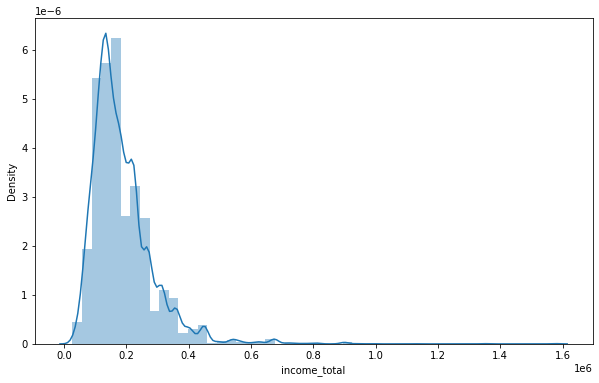

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["income_total"]);

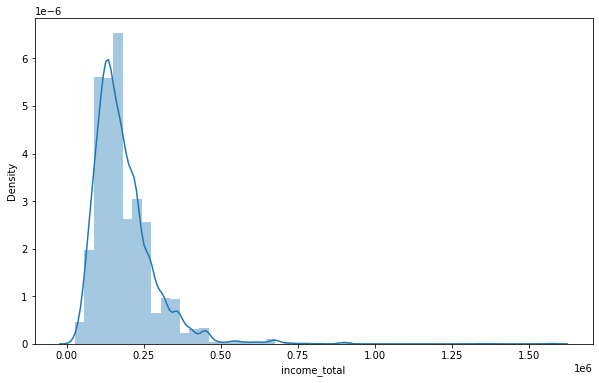

In [20]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(test["income_total"]);

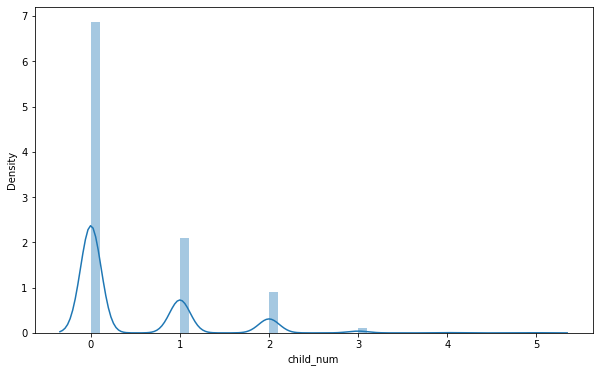

In [21]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(test["child_num"]);

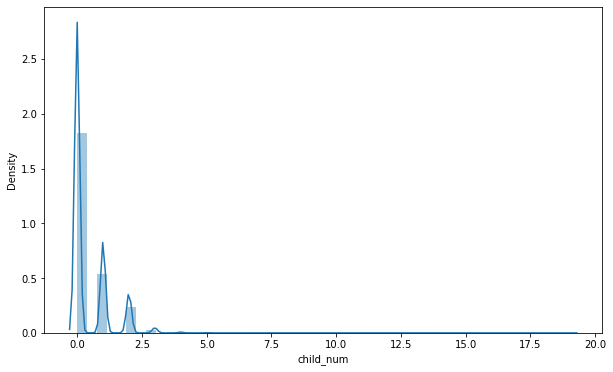

In [22]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["child_num"]);

In [23]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [24]:
#train의 child_num변수 이상치 제거(7이상 제거)
outlier = train.loc[train['child_num'] >= 7, ['child_num']]

train.drop(index = outlier.index, inplace = True)

In [25]:
train.reset_index(drop = True, inplace = True)

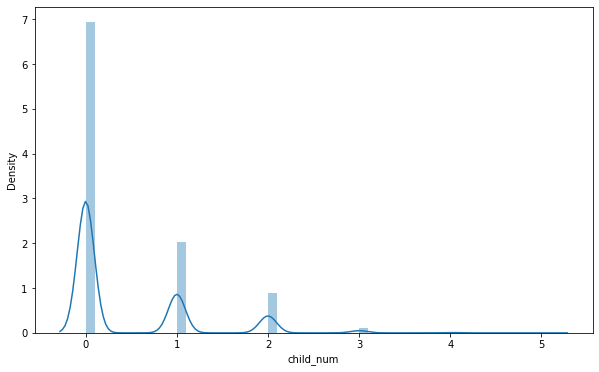

In [26]:
#이상치 제거 후 
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train["child_num"]);

In [27]:
# #income_total 변수에 log 취해줌
# def log(df):
#   df['income_total'] = np.log1p(df['income_total'])

#   return df
# log(train)
# log(test)

In [28]:
train.shape, test.shape # shape ((26457, 20), (10000, 19)) => ((21445, 19), (4994, 18)) 변경

((26451, 20), (10000, 19))

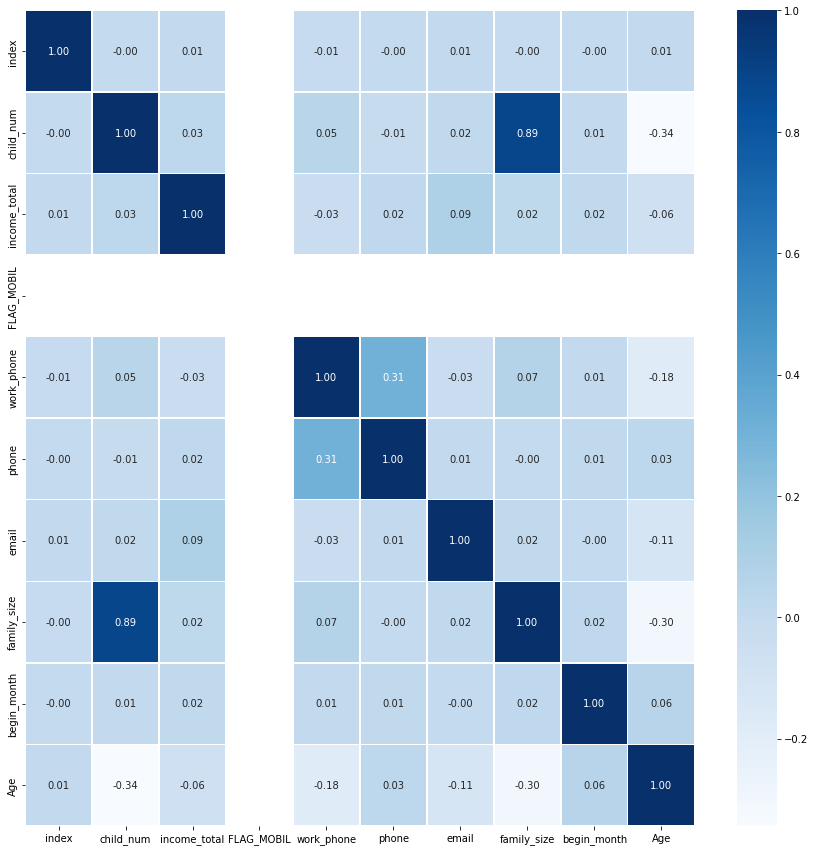

In [29]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [30]:
train['FLAG_MOBIL'].unique() #모든 값이 1로 동일

array([1])

In [31]:
# 의미없는 변수 제거(FLAG_MOBIL 모든 값이 1로 동일, 'chlid_num','family_size'는 상관관계가 높으므로 둘 중 하나 제거)
def mobil(df):
  df.drop(columns = ['FLAG_MOBIL'], inplace = True)
  df.drop(columns = ['family_size'], inplace = True)
  return df

mobil(train)
mobil(test)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,begin_month,Age,ID
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0,1,0,inoccupation,60.0,60,0_112500.0_0_1_0_2.0_M_Y_N_Pensioner_Secondary...
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,0,1,0,Core staff,36.0,51,0_135000.0_0_1_0_2.0_F_N_Y_State servant_Highe...
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,1,1,0,Laborers,40.0,43,0_69372.0_1_1_0_2.0_F_N_Y_Working_Secondary / ...
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,0,Drivers,41.0,52,0_112500.0_1_0_0_2.0_M_Y_N_Commercial associat...
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,1,0,0,Managers,8.0,48,0_225000.0_1_0_0_2.0_F_Y_Y_State servant_Highe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,1,1,0,Accountants,19.0,50,0_202500.0_1_1_0_2.0_F_Y_Y_Working_Incomplete ...
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,Laborers,34.0,29,0_202500.0_1_0_0_2.0_M_Y_Y_Working_Secondary /...
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Medicine staff,55.0,57,0_292500.0_0_0_0_2.0_F_N_Y_Working_Secondary /...
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,inoccupation,33.0,45,0_180000.0_0_1_0_2.0_F_Y_N_Commercial associat...


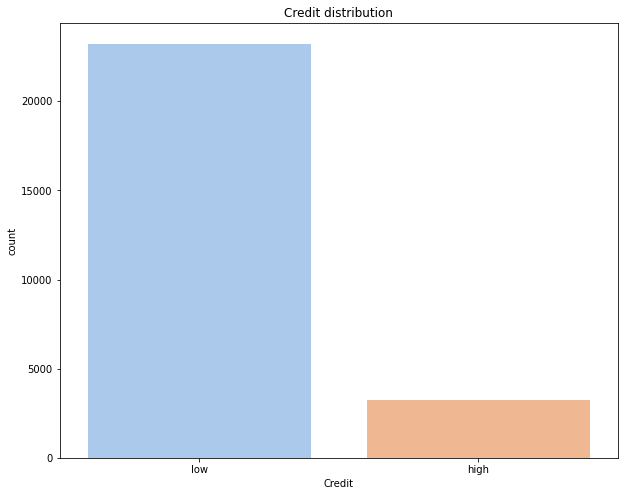

In [32]:
plt.figure(figsize = (10, 8))
sns.countplot(data = train, x = "Credit",palette="pastel")
plt.title('Credit distribution')
plt.show()

In [33]:
Group_gender = train.groupby('gender').count()['index']
Group_gender = pd.DataFrame(Group_gender)

In [34]:
Group_gender

,index
gender,
F,17694
M,8757


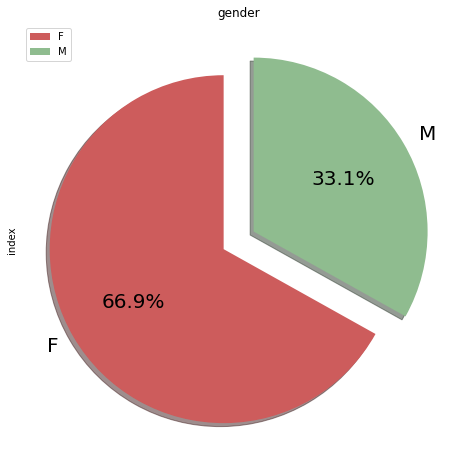

In [35]:
# 성별 비율
Group_gender['index'].plot(kind = 'pie', figsize = (10, 8), autopct = '%1.1f%%', explode = (0.1, 0.1),
                           colors = ['indianred', 'darkseagreen'],
                           startangle = 90, title = 'gender', fontsize = 20, shadow = True, legend = True);

#1. 성별에 따른 신용도 

In [36]:
Group_gender_credit = train.groupby(['gender', 'Credit'])['Credit'].count()
Group_gender_credit = pd.DataFrame(Group_gender_credit)
Group_gender_credit

Credit
gender Credit        
F      high      2148
       low      15546
M      high      1074
       low       7683

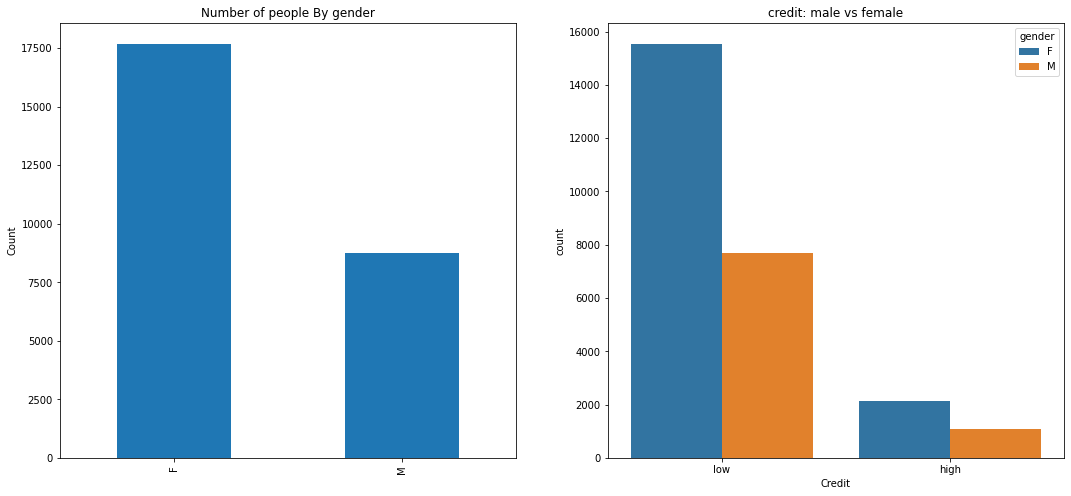

In [37]:
# 성별에 따른 신용도 
# => 여성이 남성에 비해 신용도가 낮은걸로 보이지만, 수집 된 데이터에서 여성이 2배 정도 더 많고 신용도 결과 값도 2배 정도 차이나므로 성별에 따른 신용도는 큰 차이가 없다고 볼 수 있다.
f,ax=plt.subplots(1,2,figsize=(18,8))
train['gender'].value_counts().plot.bar(ax = ax[0])
ax[0].set_title('Number of people By gender')
ax[0].set_ylabel('Count')
sns.countplot('Credit',hue='gender',data = train, ax=ax[1])
ax[1].set_title('credit: male vs female')
plt.show()

#2. 총소득에 따른 신용도

In [38]:
train['income_total']

0        202500.0
1        247500.0
2        450000.0
3        202500.0
4        157500.0
           ...   
26446    225000.0
26447    180000.0
26448    292500.0
26449    171000.0
26450     81000.0
Name: income_total, Length: 26451, dtype: float64

In [39]:
train['Credit'].value_counts()

low     23229
high     3222
Name: Credit, dtype: int64

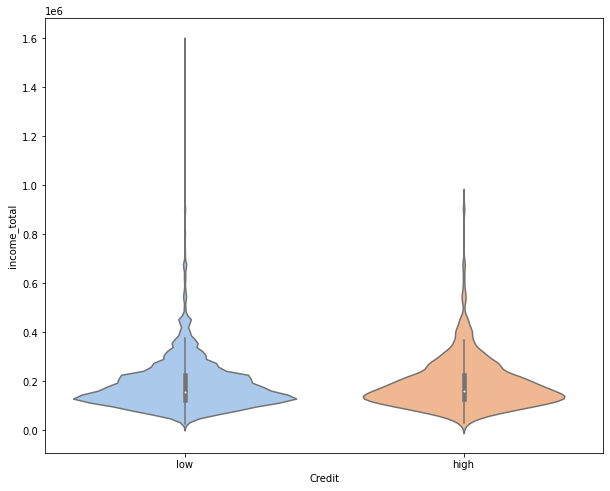

In [40]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = train['Credit'], y = train['income_total'], palette = 'pastel');

In [41]:
# train['income_total'].unique()

In [42]:
# high_income_total = train.loc[train['income_total'] >= 12.0, ['income_total', 'Credit']]
# high_income_total

In [43]:
# low_income_total = train.loc[train['income_total'] < 12.0, ['income_total', 'Credit']]
# low_income_total

In [44]:
# f,ax=plt.subplots(1,2,figsize=(18,8))
# high_income_total['Credit'].value_counts().plot.bar(ax = ax[0])
# ax[0].set_title('Distribution of Credit by high_income_total')
# ax[0].set_ylabel('Count')

# low_income_total['Credit'].value_counts().plot.bar(ax = ax[1])
# ax[1].set_title('Distribution of Credit by low_income_total')
# ax[1].set_ylabel('Count')
# plt.show() #소득이 높은 사람과 낮은 사람 모두 신용도가 낮은 사람의 분포가 더 크다 => target 데이터의 양이 low가 더 많기 때문으로 생각됨.

In [45]:
high_income_total = train.loc[train['Credit'] == 'high', ['income_total', 'Credit']]
low_income_total = train.loc[train['Credit'] == 'low', ['income_total', 'Credit']]

In [46]:
def num_plot(column):
  
  fig, axes = plt.subplots(1, 2, figsize=(18, 8))


  sns.distplot(high_income_total[column],
                ax = axes[0])
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = high')
  axes[0].set_ylabel('count')

  sns.distplot(low_income_total[column],
                ax = axes[1])
  axes[1].tick_params(labelsize=12)
  axes[1].set_title('credit = low')
  axes[1].set_ylabel('count')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)

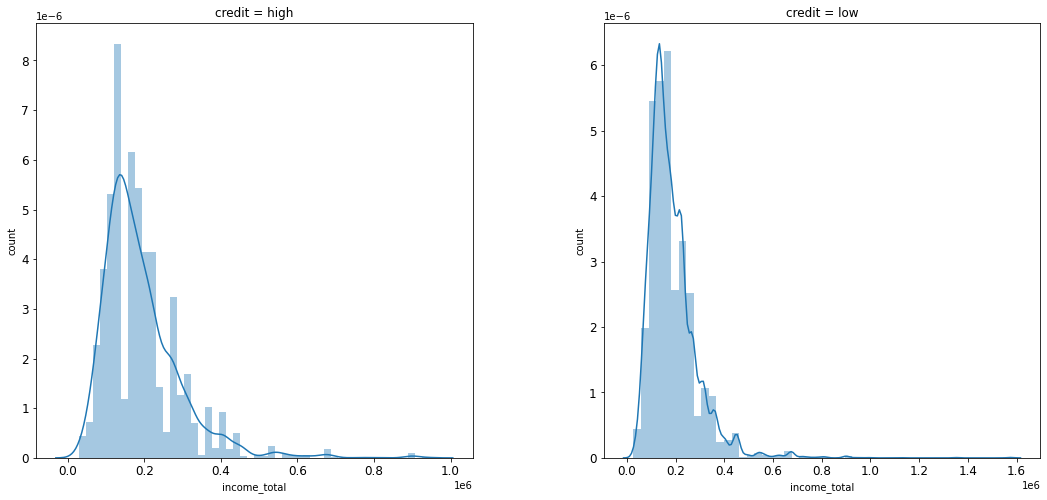

In [47]:
num_plot('income_total')

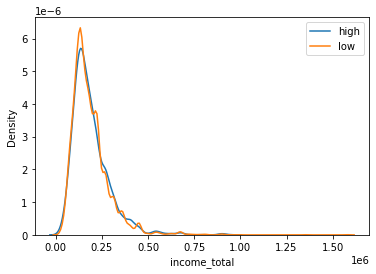

In [48]:
sns.distplot(high_income_total['income_total'],label='high', hist=False)
sns.distplot(low_income_total['income_total'],label='low', hist=False)
plt.legend()

#3. 나이에 따른 신용도

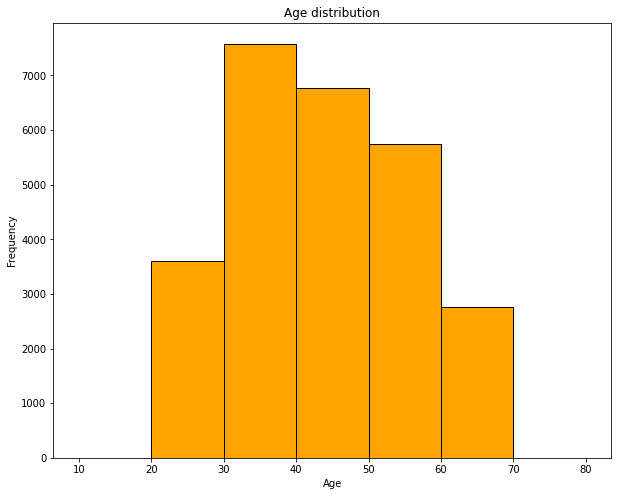

In [49]:
# 나이 분포 => 30~50대가 많다.
plt.figure(figsize = (10, 8))
train['Age'].plot.hist(bins=range(10,81,10),color='orange', edgecolor='k')
plt.xlabel('Age')
plt.title('Age distribution')
plt.show()

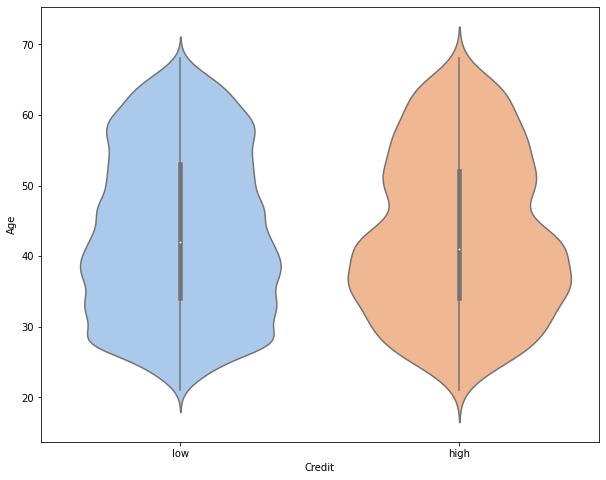

In [50]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = train['Credit'], y = train['Age'], palette = 'pastel');

In [51]:
Group_age_high = train.loc[train['Credit'] == 'high', ['Credit', 'Age']]
Group_age_high.head()

,Credit,Age
3,high,41
7,high,40
12,high,32
15,high,35
22,high,41


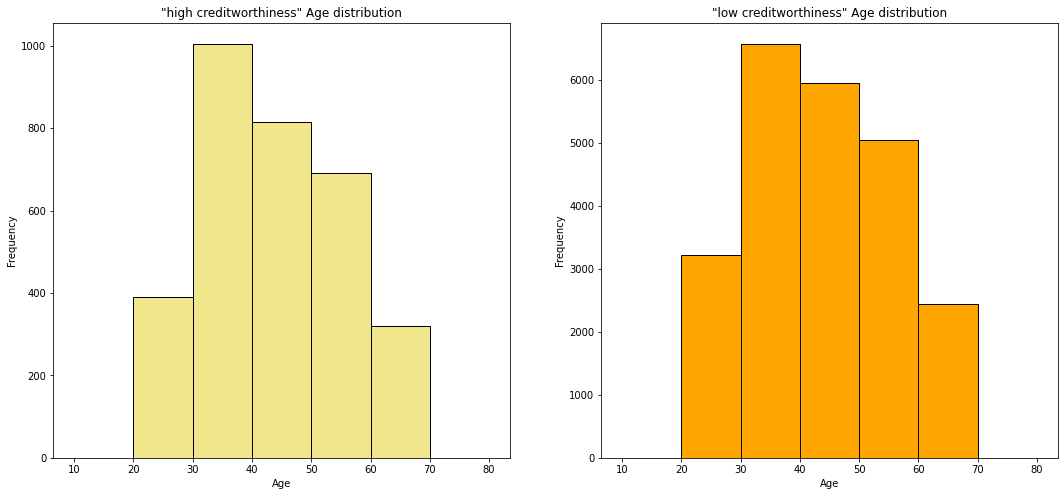

In [52]:
f,ax=plt.subplots(1,2,figsize=(18,8))
Group_age_high['Age'].plot.hist(bins=range(10,81,10),color='khaki', edgecolor='k', ax = ax[0])
ax[0].set_xlabel('Age')
ax[0].set_title('"high creditworthiness" Age distribution')

Group_age = train.loc[train['Credit'] == 'low', ['Credit', 'Age']]
Group_age['Age'].plot.hist(bins=range(10,81,10),color='orange', edgecolor='k', ax = ax[1])
ax[1].set_xlabel('Age')
ax[1].set_title('"low creditworthiness" Age distribution')
plt.show()

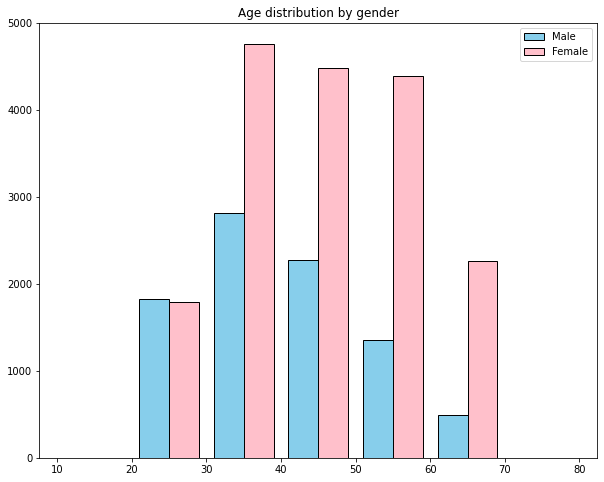

In [53]:
# 성별에 따른 분포
sex = train.groupby('gender')
M_group= sex.get_group('M')['Age']
F_group= sex.get_group('F')['Age']

plt.figure(figsize = (10, 8))

plt.hist([M_group,F_group], bins=range(10,81,10), color = ['skyblue', 'pink'], label=['Male', 'Female'], edgecolor = 'k');
plt.legend(loc='upper right');
plt.title('Age distribution by gender')
plt.show();

#4. 직업 유형에 따른 신용도


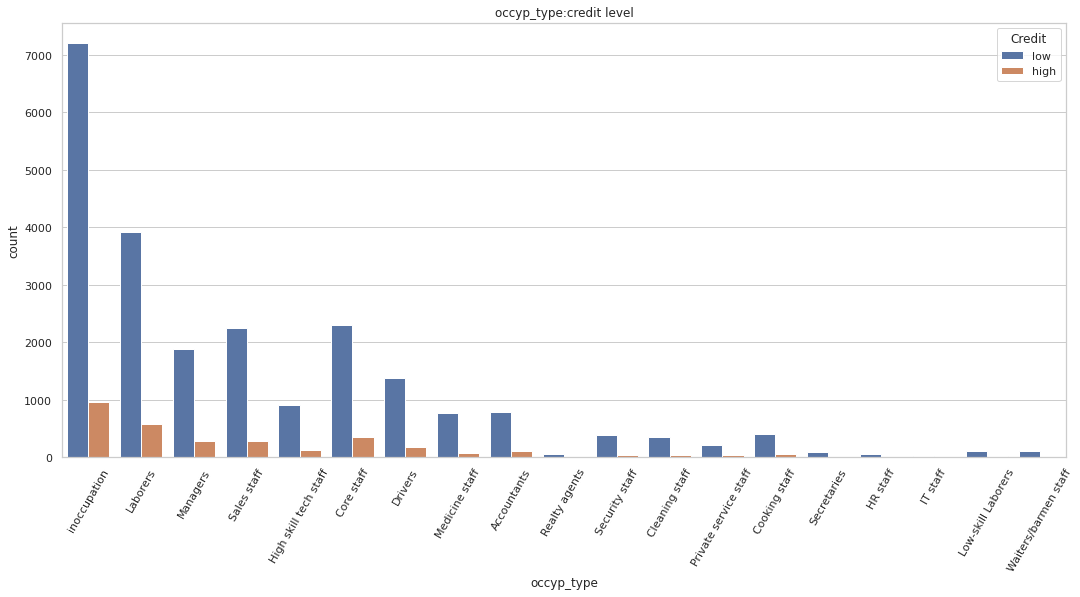

In [54]:
plt.figure(figsize = (18, 8))

sns.set_theme(style="whitegrid")
sns.countplot('occyp_type',hue = 'Credit',data = train)
plt.title('occyp_type:credit level')
plt.xticks(rotation=60)
plt.show()

In [55]:
train['income_type'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student'], dtype=object)

In [56]:
Group_income_type = train.groupby('income_type').count()['index']
Group_income_type = pd.DataFrame(Group_income_type)


In [57]:
Group_income_type.index.unique()

Index(['Commercial associate', 'Pensioner', 'State servant', 'Student',
       'Working'],
      dtype='object', name='income_type')

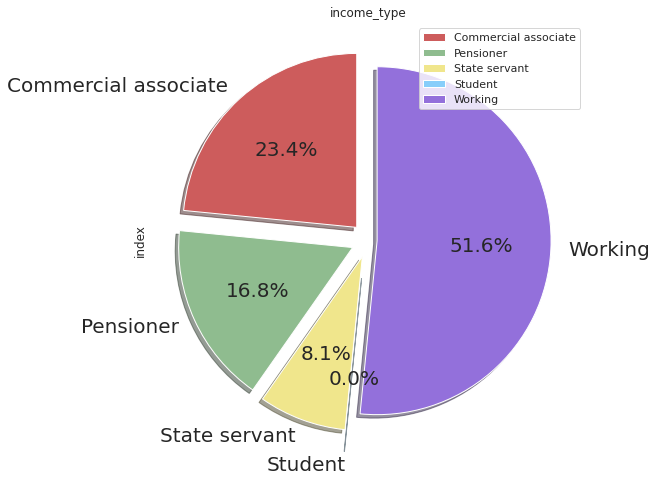

In [58]:
# 소득 분류 비율 => 대부분 노동자 이다.
Group_income_type['index'].plot(kind = 'pie', figsize = (10, 8), autopct = '%1.1f%%', explode = (0.1, 0.1, 0.1, 0.2, 0.05),
                           colors = ['indianred', 'darkseagreen', 'khaki', 'lightskyblue', 'mediumpurple'],
                           startangle = 90, title = 'income_type', fontsize = 20, shadow = True, legend = True);
                  #          'khaki', 'darkseagreen', 'mediumseagreen', 'mediumaquamarine',
                  # 'steelblue','skyblue', 'lightskyblue', 'rebeccapurple', 'mediumpurple', 'mediumslateblue'

In [59]:
train['family_type'].unique()

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [60]:
Group_family_type = train.groupby('family_type').count()['index']
Group_family_type = pd.DataFrame(Group_family_type)
Group_family_type

,index
family_type,
Civil marriage,2123
Married,18194
Separated,1536
Single / not married,3495
Widow,1103


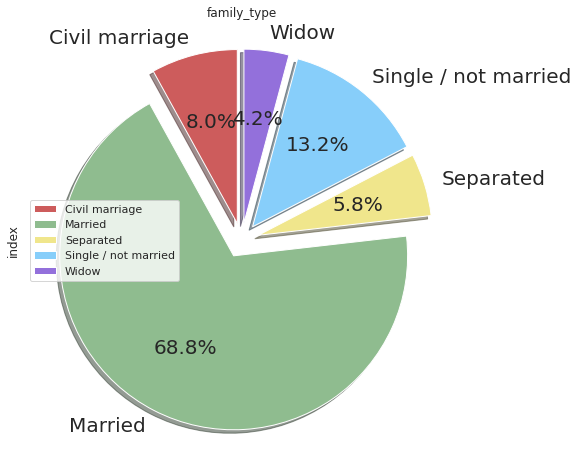

In [61]:
# 결혼 여부 분포
Group_family_type['index'].plot(kind = 'pie', figsize = (10, 8), autopct = '%1.1f%%', explode = (0.1, 0.1, 0.1, 0.1, 0.1),
                           colors = ['indianred', 'darkseagreen', 'khaki', 'lightskyblue', 'mediumpurple'],
                           startangle = 90, title = 'family_type', fontsize = 20, shadow = True, legend = True);
plt.legend(loc='center left')

In [62]:
Group_edu_type = train.groupby('house_type').count()['index']
Group_edu_type = pd.DataFrame(Group_edu_type).reset_index()
Group_edu_type 

,house_type,index
0,Co-op apartment,110
1,House / apartment,23647
2,Municipal apartment,818
3,Office apartment,190
4,Rented apartment,429
5,With parents,1257


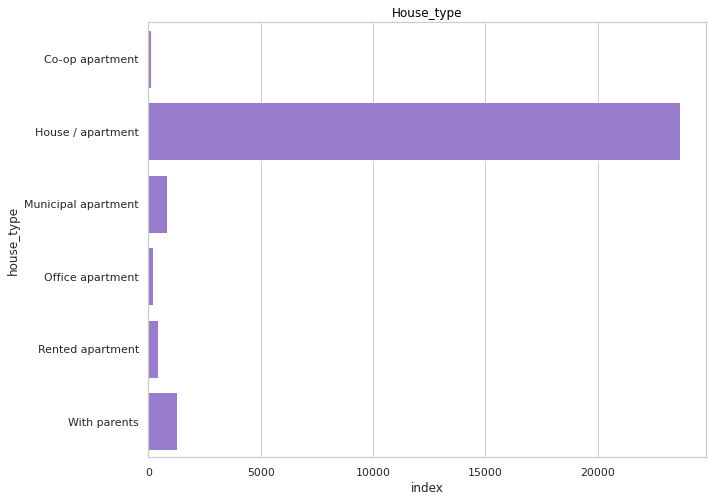

In [63]:
# 생활방식 분포 => 주택/아파트가 가장 많음.
plt.figure(figsize = (10, 8))
sns.barplot(data = Group_edu_type , y = "house_type", x = "index", orient = 'h',
            color = 'mediumpurple')
title_color = 'black'
plt.title('House_type',color=title_color)
plt.show()

##모델링

In [64]:
def drop(df):
  df.drop(columns = ['index'], inplace = True)

  return df

drop(train)
drop(test)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,begin_month,Age,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0,1,0,inoccupation,60.0,60,0_112500.0_0_1_0_2.0_M_Y_N_Pensioner_Secondary...
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,0,1,0,Core staff,36.0,51,0_135000.0_0_1_0_2.0_F_N_Y_State servant_Highe...
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,1,1,0,Laborers,40.0,43,0_69372.0_1_1_0_2.0_F_N_Y_Working_Secondary / ...
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,0,Drivers,41.0,52,0_112500.0_1_0_0_2.0_M_Y_N_Commercial associat...
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,1,0,0,Managers,8.0,48,0_225000.0_1_0_0_2.0_F_Y_Y_State servant_Highe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,1,1,0,Accountants,19.0,50,0_202500.0_1_1_0_2.0_F_Y_Y_Working_Incomplete ...
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,Laborers,34.0,29,0_202500.0_1_0_0_2.0_M_Y_Y_Working_Secondary /...
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Medicine staff,55.0,57,0_292500.0_0_0_0_2.0_F_N_Y_Working_Secondary /...
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,inoccupation,33.0,45,0_180000.0_0_1_0_2.0_F_Y_N_Commercial associat...


In [65]:
from sklearn.model_selection import train_test_split

target = 'Credit'
features = train.drop(columns = [target]).columns
train, val = train_test_split(train, train_size = 0.80, stratify = train[target], random_state = 2)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [66]:
val[target].value_counts()

low     4647
high     644
Name: Credit, dtype: int64

In [67]:
#기준모델 정확도
from sklearn.metrics import accuracy_score

major = val[target].mode()[0]
pred = [major] * len(val[target])
print("baseline accuracy: ", accuracy_score(y_val, pred))

baseline accuracy:  0.8782838782838783


## XGBoost

In [68]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [69]:
ratio = 644/4647
ratio

0.1385840327092748

In [70]:
processor = make_pipeline(
    OrdinalEncoder()
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train),
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.56327	validation_1-auc:0.564516
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.566662	validation_1-auc:0.566503
[2]	validation_0-auc:0.582792	validation_1-auc:0.582547
[3]	validation_0-auc:0.58348	validation_1-auc:0.58113
[4]	validation_0-auc:0.584305	validation_1-auc:0.584757
[5]	validation_0-auc:0.586341	validation_1-auc:0.587298
[6]	validation_0-auc:0.58586	validation_1-auc:0.587362
[7]	validation_0-auc:0.588499	validation_1-auc:0.586515
[8]	validation_0-auc:0.588758	validation_1-auc:0.578391
[9]	validation_0-auc:0.59355	validation_1-auc:0.582693
[10]	validation_0-auc:0.593689	validation_1-auc:0.583658
[11]	validation_0-auc:0.596517	validation_1-auc:0.594097
[12]	validation_0-auc:0.598634	validation_1-auc:0.595016
[13]	validation_0-auc:0.601013	validation_1-auc:0.598588
[14]	validation_0-auc:0.600788	validation_1-auc:0.597708
[15

XGBClassifier(n_estimators=1000, n_jobs=-1, scale_pos_weight=0.1385840327092748,
              verbosity=0)

In [71]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_val_processed)[:, class_index]
print(f'val AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_val, y_pred_proba))

val AUC for class "low":
0.6228743048009335


In [72]:
from sklearn.metrics import classification_report
y_val_pred = model.predict(X_val_processed)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

        high       0.18      0.44      0.26       644
         low       0.90      0.72      0.80      4647

    accuracy                           0.69      5291
   macro avg       0.54      0.58      0.53      5291
weighted avg       0.82      0.69      0.74      5291



In [ ]:
from xgboost import XGBClassifier

target = 'Credit'
features = train.drop(columns = [target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
    )
gbm_param_grid = {
    'simpleimputer__strategy': ['mean', 'median','most_frequent'],
    'xgbclassifier__learning_rate': np.array([0.01,0.001]),
    'xgbclassifier__n_estimators': np.array([100,200,300,400]),
    'xgbclassifier__subsample': np.array([0.7,0.8,0.9]),
    'xgbclassifier__max_depth': np.array([10,11,12,13,14,15,16,17]),
    'xgbclassifier__lambda': np.array([1]),
    'xgbclassifier__gamma': np.array([0]),
    'xgbclassifier__colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=gbm_param_grid, 
    n_iter=50, 
    cv=3, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

print('최적 하이퍼파라미터: ', clf_forest.best_params_)
print('Auc: ', clf_forest.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


## Shap

In [83]:
df_p = pd.DataFrame({
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_val # 실제값
})

df_p

,pred_proba,status_group
20274,0.615567,low
12344,0.505382,low
17284,0.511896,low
6670,0.518202,low
12389,0.483381,low
...,...,...
25878,0.318161,low
24859,0.506543,low
24034,0.494326,low
17283,0.567311,high


In [84]:
low = df_p['status_group'] == 'low'
high = ~low
right = (low) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [87]:
df_p[low & right].head(3).sort_values(by='pred_proba')

,pred_proba,status_group
12344,0.505382,low
17284,0.511896,low
20274,0.615567,low


In [90]:
row = X_val.iloc[[2]]
row

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,begin_month,Age,ID
17284,F,N,Y,1,315000.0,State servant,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Core staff,7.0,30,1_315000.0_0_0_1_3.0_F_N_Y_State servant_Secon...


In [91]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [92]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [93]:
shap_values

array([[-2.5364634e-04,  1.9719332e-02,  8.8875451e-05, -3.3156779e-02,
        -9.0512164e-02,  4.4990191e-03, -2.4633082e-03, -2.5318660e-02,
         1.8330302e-02, -7.4089112e-05,  1.5739209e-03,  1.1917454e-01,
        -2.3429412e-02, -1.4378409e-01, -2.3515640e-02,  2.2823702e-01]],
      dtype=float32)

In [94]:
shaps

(gender, F)                                                                                                                -0.000254
(car, N)                                                                                                                    0.019719
(reality, Y)                                                                                                                0.000089
(child_num, 1)                                                                                                             -0.033157
(income_total, 315000.0)                                                                                                   -0.090512
(income_type, State servant)                                                                                                0.004499
(edu_type, Secondary / secondary special)                                                                                  -0.002463
(family_type, Civil marriage)                                        

In [95]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [96]:
print('low 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

low 예측에 대한 Positive 요인 Top 3 입니다:
1. ID : 1_315000.0_0_0_1_3.0_F_N_Y_State servant_Secondary / secondary special_Civil marriage_House / apartment_Core staff
2. email : 1
3. car : N


Negative 요인 Top 3 입니다:
1. begin_month : 7.0
2. income_total : 315000.0
3. child_num : 1


In [97]:
def explain(row_number):
    positive_class = 'low'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 사람의 신용도 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [110]:
explain(1500)

이 사람의 신용도 대한 예측결과는 low 으로, 확률은 64% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. ID : 0_135000.0_1_0_0_2.0_F_N_N_Commercial associate_Higher education_Married_House / apartment_HR staff
2. occyp_type : HR staff
3. Age : 40


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. begin_month : 3.0
2. child_num : 0
3. email : 0


In [100]:
X_val_processed.shape

(5291, 16)

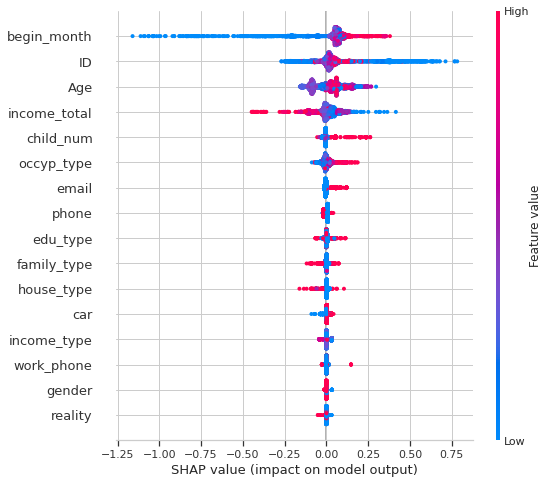

In [102]:
shap_values = explainer.shap_values(X_val_processed.iloc[:3000])
shap.summary_plot(shap_values, X_val_processed.iloc[:3000])

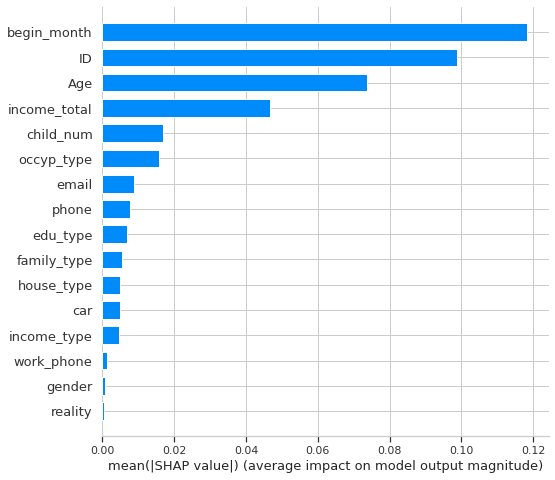

In [103]:
shap.summary_plot(shap_values, X_val_processed.iloc[:3000], plot_type="bar")

In [ ]:
# encoder = OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_test_encoded = encoder.transform(X_test)

## RandomForest

In [ ]:
target = 'Credit'
features = train.drop(columns = [target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]

In [ ]:
from scipy.stats import randint, uniform

pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

dists = {
    'randomforestclassifier__class_weight': ['balanced', None, {'high':7, 'low':1}], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [10, 15, 20, 25, 30], 
    'randomforestclassifier__max_features': uniform(0, 1) 
}

clf_forest = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

clf_forest.fit(X_train, y_train);

# dists = {
#     'class_weight' : ['balanced', None, {'high':7, 'low':1}],
#     'n_estimators': randint(50, 500), 
#     'max_depth': [10, 15, 20, 25, 30, None], 
#     'max_features': uniform(0, 1), 
# }

# clf = RandomizedSearchCV(
#     RandomForestClassifier(random_state = 42), 
#     param_distributions = dists, 
#     n_iter=5, 
#     cv=3, 
#     scoring='roc_auc', 
#     verbose=10, 
#     return_train_score = True, 
#     n_jobs=-1, 
#     random_state = 42
# )

# clf.fit(X_train_encoded, y_train);

In [ ]:
print('최적 하이퍼파라미터: ', clf_forest.best_params_)
print('Auc: ', clf_forest.best_score_)
model = clf_forest.best_estimator_['randomforestclassifier']

In [ ]:
processor = clf_forest.best_estimator_['ordinalencoder']

In [ ]:
row_forest = X_test.iloc[:300]

In [ ]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row_forest)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row_forest, 
    link='logit'
)

In [ ]:
shap_values

In [ ]:
X_train_preprocessed = processor.fit_transform(X_train)
X_test_preprocessed = processor.transform(X_test)

In [ ]:
shap_values = explainer.shap_values(X_test_preprocessed.iloc[:300])
shap.summary_plot(shap_values, X_test_preprocessed.iloc[:300])

In [ ]:
shap_values

In [ ]:
# import shap

# explainer = shap.TreeExplainer(model)
# row_processed = preprocess_pipeline.transform(row)
# shap_values = explainer.shap_values(row_processed)

# shap.initjs()
# shap.force_plot(
#     base_value=explainer.expected_value, 
#     shap_values=shap_values, 
#     features=row, 
#     link='logit' # SHAP value를 확률로 변환해 표시합니다.
# )

In [ ]:
# print('최적 하이퍼파라미터: ', clf.best_params_)
# print('Auc: ', clf.best_score_)

In [ ]:
# from sklearn.model_selection import train_test_split
# train, val = train_test_split(train, train_size = 0.80, stratify = train[target], random_state = 2)

# X_train = train[features]
# y_train = train[target]
# X_val = val[features]
# y_val = val[target]
# X_test = test[features]

# pipe = make_pipeline(
#     OrdinalEncoder(), 
#     SimpleImputer(), 
#     RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators = 2000, oob_score=True))

# pipe.fit(X_train, y_train)
# print('검증 정확도', pipe.score(X_val, y_val))

In [ ]:
# from sklearn.metrics import roc_auc_score

# y_pred_proba = pipe.predict_proba(X_val)[:, 1]
# print('Auc score', roc_auc_score(y_val, y_pred_proba))